In [2]:
import os

os.chdir('/Users/hugocoussens/OneDrive - Imperial College London/MSc_Project/Seismic-Dimensionality-Reduction/Project-Files')  

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import random

# Dim reduction tools
import umap
from sklearn.linear_model import LinearRegression
import torch
import torch.utils.data
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.model_selection import ShuffleSplit


import utils
import segypy 

/Users/hugocoussens/OneDrive - Imperial College London/MSc_Project/Seismic-Dimensionality-Reduction/Project-Files


### MY Classses

In [4]:
class DataHolder:
    def __init__(self, field_name, inlines, xlines):
        
        # User input attributes
        self.field_name = field_name
        self.inlines = inlines
        self.xlines = xlines

        # near and far offset seismic data
        self.near = None
        self.far = None
        self.twt = None
        
        # Dictionaries for multiple possible entries
        self.horizons = {}
        self.wells = {}
        
        
    def add_segy(self, name, fname):
        if name == 'near':
            self.near, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        elif name == 'far':
            self.far, twt = load_seismic(fname, inlines=self.inlines, xlines=self.xlines)
        else:
            raise Exception('please specify if near or far data')
            
        if self.twt is None:
            self.twt = twt
        else: assert (self.twt == twt).all, "This twt does not match the twt from the previous segy"
        
    def add_horizon(self, horizon_name, fname):
        self.horizons[horizon_name] = interpolate_horizon(load_horizon(fname, inlines=self.inlines, xlines=self.xlines))
        
    def add_well(self, well_id, well_i, well_x):
        self.wells[well_id] = [well_i, well_x]
        
        
class Processor:
    def __init__(self, near=None, far=None, twt=None):
        self.raw = [near, far]
        self.twt = twt
        self.out = None
    
    def flatten(self, data, horizon, top_add=12, below_add=52):
        out = []
        for amplitude in data:
            traces = np.zeros((horizon.shape[0], horizon.shape[1], top_add+below_add))
            for i in range(horizon.shape[0]):
                hrz_idx = [np.abs(self.twt-val).argmin() for val in horizon[i, :]] 
                for j in range(horizon.shape[1]):
                    traces[i, j, :] = amplitude[hrz_idx[j]-top_add:hrz_idx[j]+below_add, i, j]
            out.append(traces)
        return out
    
    def normalise(self, data, well_i=38, well_x=138):
        out = []
        for i in data:
            well_variance = np.mean(np.std(i[well_i - 2:well_i + 1, well_x - 2:well_x + 1], 2))
            i /= well_variance
            out.append(i)

        return out
        

    def to_2d(self, data):
        return [i.reshape(-1, data[0].shape[-1]) for i in data]
        
    def average_neighbours(self, neighbours=10):
        return 'not implemented yet'
        
    
    def stack_traces(self, data):
        return np.concatenate([i for i in data], 1)
    
    @property
    def FF(self):
        x_avo = self.out[0]
        y_avo = self.out[1] - self.out[0]

        lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
        lin_reg.fit(x_avo.reshape(-1, 1), y_avo.reshape(-1, 1))

        print("Linear Regression coefficient: %1.2f" % lin_reg.coef_[0, 0])
        return y_avo - lin_reg.coef_ * x_avo
    
    def __call__(self, flatten=False, normalise=False, label='FF'):
        self.out = copy.copy(self.raw)
        
        if flatten:
            self.out = self.flatten(self.out, flatten[0], flatten[1], flatten[2])
        if normalise:
            self.out = self.normalise(self.out, normalise[0], normalise[1])
        
        # Flatten arrays from 3d to 2d
        self.out = self.to_2d(self.out)
        
        # Pre-stacking calculation of FF
        if label == 'FF':
            self.label = self.FF
            
        # Stack the traces for output
        self.out = self.stack_traces(self.out)
        
        return self.out, self.label    

In [32]:
class ModelAgent:
    def __init__(self, data):
        self.input = data[0]
        self.label = data[1]
        print("ModelAgent initialised")
        
    def plot_2d(self, data, label):
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        sc = ax.scatter(data[:, 0], data[:, 1], s=2.0, c=np.min(label, 1))
#         colorbar(sc)
        return 1
        
    def plot_3d(self, data, feature):
        return 'Not implemented'
        
        
class UMAP(ModelAgent):
    def __init__(self, data):
        super().__init__(data)

    
    def reduce(self, n_neighbors = 50, min_dist=0.001):
        embedding_stack_ff = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation', 
                               verbose=False,
#   this was in ASAP notebook: random_state=42).fit_transform(np.concatenate([stacked, FF.reshape(-1, 64)], 1))
                            random_state=42).fit_transform(self.input)
        
        return embedding_stack_ff
    
    
    
class VAE_model(ModelAgent):
    def __init__(self, data):
        super().__init__(data)
    
    def create_dataloader(self, batch_size=32):
        # split the concatenated input back into two arrays
        X = torch.from_numpy(np.stack(np.split(self.input, 2, axis=1), 1)).float()
        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        print('adf', X.shape)
        
        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True, **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=False, **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset, batch_size=batch_size, shuffle=False, **kwargs)
        
    def train_vae(self, cuda=False, epochs=30):
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size=8)  # Inititalize the model

        # use cuda if chosen
        if cuda:
            self.model.cuda()

        # Create a gradient descent optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=1e-2, betas=(0.9, 0.999))

        # Store and plot losses
        self.losses = []

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch, self.model, optimizer, self.train_loader, cuda=False)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, cuda=False)  # Validate model on test dataset
            self.losses.append([tl, testl])
        
    def run_vae(self):
        _, self.zs = forward_all(self.model, self.all_loader, cuda=False)
        
    def vae_umap(self):
        transformer = umap.UMAP(n_neighbors=5,
                                min_dist=0.001,
                                metric='correlation', verbose=True).fit(self.zs.numpy())
        embedding = transformer.transform(self.zs.numpy())
        print('shape of zs', self.zs.shape)

        # plot umap
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        sc = ax.scatter(embedding[::, 0], embedding[::, 1], s=2.0, c=np.min(self.label, 1)[::])
        plt.show()
    
    def reduce(self, alpha=0.01):
        self.create_dataloader()
        self.train_vae()
        self.run_vae()
        self.vae_umap()



In [9]:
### Client loader
Glitne = DataHolder("Glitne", [1300, 1502, 2], [1500, 2002, 2])
Glitne.add_segy('near', '../data/3d_nearstack.sgy');
Glitne.add_segy('far', '../data/3d_farstack.sgy');
Glitne.add_horizon('top_heimdal', '../data/Top_Heimdal_subset.txt')
Glitne.add_well('well_1', 36, 276//2)


SegyPY0.57:  readSegy : Trying to read ../data/3d_nearstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ../data/3d_nearstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data
SegyPY0.57:  readSegy : Trying to read ../data/3d_farstack.sgy
SegyPY0.57:  getSegyHeader : succesfully read ../data/3d_farstack.sgy
SegyPY0.57:  filesize=31438840
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=7858810
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=250
SegyPY0.57:  readSegyData : Finished reading segy data


In [29]:
### Client data factory - would run diffetent instances of Processing with different operations
# instance of processing creates options for many outputs
Data = Processor(Glitne.near, Glitne.far, Glitne.twt)
processing_a = Data([Glitne.horizons['top_heimdal'], 12,52], [10, 20])
processing_b = Data([Glitne.horizons['top_heimdal'], 10,10], [10, 20])


### Client model creator/run - run many different instances of the VAE with different parameters
# an instance of a model is one model of dim reduction
UMAP_a = UMAP(processing_a)
# UMAP_a1 = UMAP_a.reduce(n_neighbors=10)
# UMAP_a2 = UMAP_a.reduce(n_neighbors=100)



Linear Regression coefficient: -0.87
Linear Regression coefficient: -0.86
ModelAgent initialised


ModelAgent initialised
adf torch.Size([25351, 2, 64])
Train Epoch: 1 [0/12675 (0%)]	Loss: 10.481352


/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [320/12675 (3%)]	Loss: 9.303310
Train Epoch: 1 [640/12675 (5%)]	Loss: 11.239299
Train Epoch: 1 [960/12675 (8%)]	Loss: 10.021376
Train Epoch: 1 [1280/12675 (10%)]	Loss: 8.938589
Train Epoch: 1 [1600/12675 (13%)]	Loss: 9.163144
Train Epoch: 1 [1920/12675 (15%)]	Loss: 9.049455
Train Epoch: 1 [2240/12675 (18%)]	Loss: 9.155357
Train Epoch: 1 [2560/12675 (20%)]	Loss: 9.703202
Train Epoch: 1 [2880/12675 (23%)]	Loss: 9.328272
Train Epoch: 1 [3200/12675 (25%)]	Loss: 8.579162
Train Epoch: 1 [3520/12675 (28%)]	Loss: 9.546024
Train Epoch: 1 [3840/12675 (30%)]	Loss: 8.656590
Train Epoch: 1 [4160/12675 (33%)]	Loss: 9.008051
Train Epoch: 1 [4480/12675 (35%)]	Loss: 8.425264
Train Epoch: 1 [4800/12675 (38%)]	Loss: 8.385656
Train Epoch: 1 [5120/12675 (40%)]	Loss: 9.471395
Train Epoch: 1 [5440/12675 (43%)]	Loss: 9.041152
Train Epoch: 1 [5760/12675 (45%)]	Loss: 9.029431
Train Epoch: 1 [6080/12675 (48%)]	Loss: 8.996409
Train Epoch: 1 [6400/12675 (50%)]	Loss: 9.698196
Train Epoch: 1 [6720/126

Train Epoch: 5 [960/12675 (8%)]	Loss: 8.408219
Train Epoch: 5 [1280/12675 (10%)]	Loss: 7.745733
Train Epoch: 5 [1600/12675 (13%)]	Loss: 7.795787
Train Epoch: 5 [1920/12675 (15%)]	Loss: 7.981164
Train Epoch: 5 [2240/12675 (18%)]	Loss: 7.747658
Train Epoch: 5 [2560/12675 (20%)]	Loss: 7.980639
Train Epoch: 5 [2880/12675 (23%)]	Loss: 7.727949
Train Epoch: 5 [3200/12675 (25%)]	Loss: 7.979991
Train Epoch: 5 [3520/12675 (28%)]	Loss: 7.412693
Train Epoch: 5 [3840/12675 (30%)]	Loss: 8.021866
Train Epoch: 5 [4160/12675 (33%)]	Loss: 7.522125
Train Epoch: 5 [4480/12675 (35%)]	Loss: 7.945887
Train Epoch: 5 [4800/12675 (38%)]	Loss: 7.729265
Train Epoch: 5 [5120/12675 (40%)]	Loss: 7.687046
Train Epoch: 5 [5440/12675 (43%)]	Loss: 7.777705
Train Epoch: 5 [5760/12675 (45%)]	Loss: 7.984598
Train Epoch: 5 [6080/12675 (48%)]	Loss: 7.789931
Train Epoch: 5 [6400/12675 (50%)]	Loss: 7.891513
Train Epoch: 5 [6720/12675 (53%)]	Loss: 7.889201
Train Epoch: 5 [7040/12675 (55%)]	Loss: 7.602022
Train Epoch: 5 [7360/1

Train Epoch: 9 [1600/12675 (13%)]	Loss: 7.365053
Train Epoch: 9 [1920/12675 (15%)]	Loss: 7.560055
Train Epoch: 9 [2240/12675 (18%)]	Loss: 7.317977
Train Epoch: 9 [2560/12675 (20%)]	Loss: 7.047306
Train Epoch: 9 [2880/12675 (23%)]	Loss: 7.247804
Train Epoch: 9 [3200/12675 (25%)]	Loss: 7.997336
Train Epoch: 9 [3520/12675 (28%)]	Loss: 7.191052
Train Epoch: 9 [3840/12675 (30%)]	Loss: 7.285754
Train Epoch: 9 [4160/12675 (33%)]	Loss: 7.807176
Train Epoch: 9 [4480/12675 (35%)]	Loss: 7.824623
Train Epoch: 9 [4800/12675 (38%)]	Loss: 7.716842
Train Epoch: 9 [5120/12675 (40%)]	Loss: 7.350438
Train Epoch: 9 [5440/12675 (43%)]	Loss: 7.493479
Train Epoch: 9 [5760/12675 (45%)]	Loss: 7.058369
Train Epoch: 9 [6080/12675 (48%)]	Loss: 7.821779
Train Epoch: 9 [6400/12675 (50%)]	Loss: 7.326816
Train Epoch: 9 [6720/12675 (53%)]	Loss: 7.581511
Train Epoch: 9 [7040/12675 (55%)]	Loss: 7.337377
Train Epoch: 9 [7360/12675 (58%)]	Loss: 7.239930
Train Epoch: 9 [7680/12675 (60%)]	Loss: 7.322186
Train Epoch: 9 [8000

Train Epoch: 13 [1600/12675 (13%)]	Loss: 7.675919
Train Epoch: 13 [1920/12675 (15%)]	Loss: 7.574953
Train Epoch: 13 [2240/12675 (18%)]	Loss: 7.613352
Train Epoch: 13 [2560/12675 (20%)]	Loss: 7.378984
Train Epoch: 13 [2880/12675 (23%)]	Loss: 7.693346
Train Epoch: 13 [3200/12675 (25%)]	Loss: 7.347833
Train Epoch: 13 [3520/12675 (28%)]	Loss: 7.813076
Train Epoch: 13 [3840/12675 (30%)]	Loss: 7.226207
Train Epoch: 13 [4160/12675 (33%)]	Loss: 7.311644
Train Epoch: 13 [4480/12675 (35%)]	Loss: 6.942336
Train Epoch: 13 [4800/12675 (38%)]	Loss: 7.500870
Train Epoch: 13 [5120/12675 (40%)]	Loss: 7.781966
Train Epoch: 13 [5440/12675 (43%)]	Loss: 7.443016
Train Epoch: 13 [5760/12675 (45%)]	Loss: 7.127793
Train Epoch: 13 [6080/12675 (48%)]	Loss: 7.718989
Train Epoch: 13 [6400/12675 (50%)]	Loss: 7.425181
Train Epoch: 13 [6720/12675 (53%)]	Loss: 7.020203
Train Epoch: 13 [7040/12675 (55%)]	Loss: 8.033902
Train Epoch: 13 [7360/12675 (58%)]	Loss: 7.336909
Train Epoch: 13 [7680/12675 (60%)]	Loss: 7.187661


Train Epoch: 17 [1280/12675 (10%)]	Loss: 7.211840
Train Epoch: 17 [1600/12675 (13%)]	Loss: 7.438993
Train Epoch: 17 [1920/12675 (15%)]	Loss: 7.100237
Train Epoch: 17 [2240/12675 (18%)]	Loss: 7.247633
Train Epoch: 17 [2560/12675 (20%)]	Loss: 7.429098
Train Epoch: 17 [2880/12675 (23%)]	Loss: 7.149561
Train Epoch: 17 [3200/12675 (25%)]	Loss: 7.263754
Train Epoch: 17 [3520/12675 (28%)]	Loss: 7.430843
Train Epoch: 17 [3840/12675 (30%)]	Loss: 7.299660
Train Epoch: 17 [4160/12675 (33%)]	Loss: 7.864528
Train Epoch: 17 [4480/12675 (35%)]	Loss: 7.220985
Train Epoch: 17 [4800/12675 (38%)]	Loss: 7.269531
Train Epoch: 17 [5120/12675 (40%)]	Loss: 7.407698
Train Epoch: 17 [5440/12675 (43%)]	Loss: 7.206273
Train Epoch: 17 [5760/12675 (45%)]	Loss: 7.453711
Train Epoch: 17 [6080/12675 (48%)]	Loss: 7.624596
Train Epoch: 17 [6400/12675 (50%)]	Loss: 8.005848
Train Epoch: 17 [6720/12675 (53%)]	Loss: 7.420481
Train Epoch: 17 [7040/12675 (55%)]	Loss: 7.726018
Train Epoch: 17 [7360/12675 (58%)]	Loss: 7.107565


Train Epoch: 21 [960/12675 (8%)]	Loss: 7.177692
Train Epoch: 21 [1280/12675 (10%)]	Loss: 7.722883
Train Epoch: 21 [1600/12675 (13%)]	Loss: 7.291117
Train Epoch: 21 [1920/12675 (15%)]	Loss: 7.684737
Train Epoch: 21 [2240/12675 (18%)]	Loss: 7.670538
Train Epoch: 21 [2560/12675 (20%)]	Loss: 7.089538
Train Epoch: 21 [2880/12675 (23%)]	Loss: 7.275773
Train Epoch: 21 [3200/12675 (25%)]	Loss: 7.566449
Train Epoch: 21 [3520/12675 (28%)]	Loss: 7.373277
Train Epoch: 21 [3840/12675 (30%)]	Loss: 7.191640
Train Epoch: 21 [4160/12675 (33%)]	Loss: 6.702405
Train Epoch: 21 [4480/12675 (35%)]	Loss: 6.821121
Train Epoch: 21 [4800/12675 (38%)]	Loss: 7.642513
Train Epoch: 21 [5120/12675 (40%)]	Loss: 7.208138
Train Epoch: 21 [5440/12675 (43%)]	Loss: 7.537928
Train Epoch: 21 [5760/12675 (45%)]	Loss: 7.421333
Train Epoch: 21 [6080/12675 (48%)]	Loss: 7.176007
Train Epoch: 21 [6400/12675 (50%)]	Loss: 7.983269
Train Epoch: 21 [6720/12675 (53%)]	Loss: 7.477569
Train Epoch: 21 [7040/12675 (55%)]	Loss: 7.493942
Tr

Train Epoch: 25 [640/12675 (5%)]	Loss: 7.606757
Train Epoch: 25 [960/12675 (8%)]	Loss: 7.437740
Train Epoch: 25 [1280/12675 (10%)]	Loss: 7.021151
Train Epoch: 25 [1600/12675 (13%)]	Loss: 7.843762
Train Epoch: 25 [1920/12675 (15%)]	Loss: 7.656858
Train Epoch: 25 [2240/12675 (18%)]	Loss: 7.709816
Train Epoch: 25 [2560/12675 (20%)]	Loss: 7.374841
Train Epoch: 25 [2880/12675 (23%)]	Loss: 7.311919
Train Epoch: 25 [3200/12675 (25%)]	Loss: 7.227114
Train Epoch: 25 [3520/12675 (28%)]	Loss: 7.746694
Train Epoch: 25 [3840/12675 (30%)]	Loss: 7.426779
Train Epoch: 25 [4160/12675 (33%)]	Loss: 7.484670
Train Epoch: 25 [4480/12675 (35%)]	Loss: 7.360423
Train Epoch: 25 [4800/12675 (38%)]	Loss: 7.319054
Train Epoch: 25 [5120/12675 (40%)]	Loss: 7.212687
Train Epoch: 25 [5440/12675 (43%)]	Loss: 7.639578
Train Epoch: 25 [5760/12675 (45%)]	Loss: 7.625580
Train Epoch: 25 [6080/12675 (48%)]	Loss: 7.412113
Train Epoch: 25 [6400/12675 (50%)]	Loss: 7.273298
Train Epoch: 25 [6720/12675 (53%)]	Loss: 7.233659
Trai

Train Epoch: 29 [320/12675 (3%)]	Loss: 7.239205
Train Epoch: 29 [640/12675 (5%)]	Loss: 7.320723
Train Epoch: 29 [960/12675 (8%)]	Loss: 7.545970
Train Epoch: 29 [1280/12675 (10%)]	Loss: 7.303817
Train Epoch: 29 [1600/12675 (13%)]	Loss: 7.480159
Train Epoch: 29 [1920/12675 (15%)]	Loss: 7.487690
Train Epoch: 29 [2240/12675 (18%)]	Loss: 7.885304
Train Epoch: 29 [2560/12675 (20%)]	Loss: 7.608282
Train Epoch: 29 [2880/12675 (23%)]	Loss: 7.581934
Train Epoch: 29 [3200/12675 (25%)]	Loss: 6.946050
Train Epoch: 29 [3520/12675 (28%)]	Loss: 7.256188
Train Epoch: 29 [3840/12675 (30%)]	Loss: 7.136246
Train Epoch: 29 [4160/12675 (33%)]	Loss: 7.185923
Train Epoch: 29 [4480/12675 (35%)]	Loss: 7.476057
Train Epoch: 29 [4800/12675 (38%)]	Loss: 7.244850
Train Epoch: 29 [5120/12675 (40%)]	Loss: 7.213797
Train Epoch: 29 [5440/12675 (43%)]	Loss: 7.485156
Train Epoch: 29 [5760/12675 (45%)]	Loss: 7.286326
Train Epoch: 29 [6080/12675 (48%)]	Loss: 7.273512
Train Epoch: 29 [6400/12675 (50%)]	Loss: 7.125764
Train 

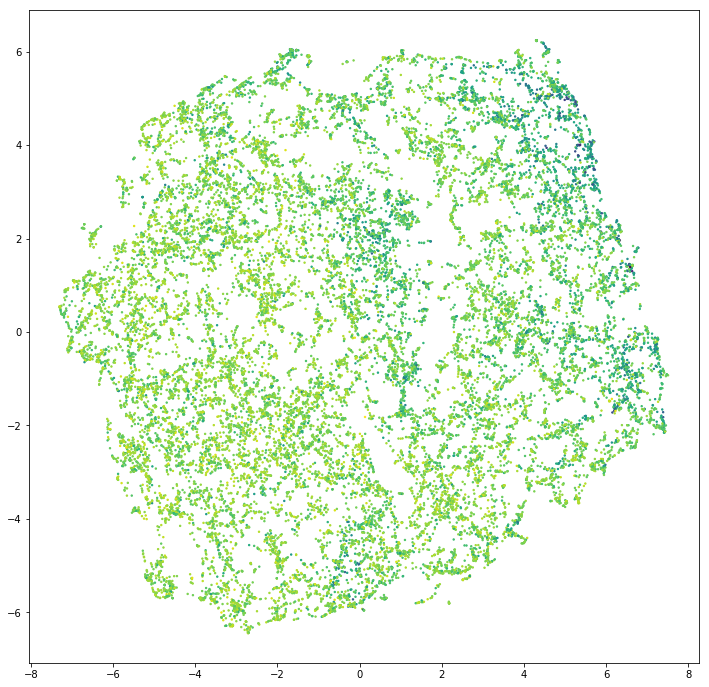

In [33]:
# give data once
VAE_a = VAE_model(processing_a)

# run with different params
VAE_a.create_dataloader()
VAE_a.train_vae()
VAE_a.run_vae()
VAE_a.vae_umap()